
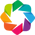

Holoviews Version:  1.9.1


In [1]:
if False:
    import sys
    hv_dev = '1.8.2'
    sys.path.insert(0, '/usr/lib/python3.6/site-packages/holoviews-'+hv_dev+'-py3.6.egg/')
else: hv_dev = ''

import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes(); sns.set_style('white')

import numpy as np
import pandas as pd
import holoviews as hv

hv.notebook_extension('bokeh', 'matplotlib')
from IPython.core.display import HTML


from jinja2 import Environment, PackageLoader, Template, select_autoescape


print( 'Holoviews Version: %s %s' % (hv_dev, hv.__version__) )

<div style="color:blue;text-align:left;font-size:25px;">Define a set of plots with options for Bokeh and for Matplotlib</div>
* generate a HoloMap of Matplotlib plots
* generate a HoloMap of Bokeh plots
* Generate SVG output
* Generate a Makefile and a Latex document including each of the plots

# Define the plots

In [2]:
SZ=8000; N=44; M=4
ddf  = pd.DataFrame( dict(err      = 5+np.random.normal(size=SZ),
                          Accept   = np.random.randint(2,size=SZ),
                          resultID = np.random.randint(N,size=SZ),
                          probID   = np.arange(SZ)
    ))
ddf.loc[ddf['resultID']==0,'Accept'] = 1


def extend_range( vals, p=.05 ):
    low = vals.min()
    hgh = vals.max()
    d   = (hgh-low)*p
    return (low-d,hgh+d)

def error_evolution_plots(df, N, backend='bokeh'):
    if backend is 'bokeh':
        print('set bokeh')
        spike_plot_opts = dict(xticks=5, yticks=5, width=600, height=300)
        scatter_style_0 = dict( size = 8, color='magenta')
        scatter_style_1 = dict( size = 8, color='blue')
    else:
        print('set matplotlib')
        spike_plot_opts = dict(xticks=5, yticks=5, fig_size=500, aspect=10)
        scatter_style_0 = dict( s = 100, color='magenta')
        scatter_style_1 = dict( s = 100, color='blue')

    # CAVEAT: workaround bug in HoloMaps
    h_bandaid = hv.Scatter( (-1000,0), kdims=['probID'], vdims=['err'] )

    d_plots = {}

    for f in np.arange(N):
        hv_df = hv.Table(df[df['resultID']==f], kdims=['probID', 'resultID'], vdims=['err','Accept'])
        if len(hv_df) is 0: continue
        pid_rng = extend_range(hv_df['probID'])
        err_rng = extend_range(hv_df['err'])

        h = hv.Spikes( hv_df, kdims=['probID'], vdims=['err']).opts(plot=spike_plot_opts)

        tmp1 = hv_df[hv_df['Accept']==1]
        if len(tmp1) > 0: h = h * hv.Scatter( tmp1, kdims=['probID'], vdims=['err'], group='Accept' ).opts(style=scatter_style_1 )
        else:             h = h * h_bandaid.opts(style=scatter_style_1)
        tmp0 = hv_df[hv_df['Accept']==0]
        if len(tmp0) > 0: h = h * hv.Scatter( tmp0, kdims=['probID'], vdims=['err'], group='Reject' ).opts(style=scatter_style_0 )
        else:             h = h * h_bandaid.opts(style=scatter_style_0)


        d_plots[f] = h.redim.range(probID=pid_rng, err=err_rng) \
                         .relabel('Error Evolution resultID = %d' % f)
    return d_plots

# Test the plots

set matplotlib


:Layout
   .HoloMap.Error_Evolution_resultID_equals_0 :HoloMap   [Default]
      :Overlay
         .Spikes.I :Spikes   [probID]   (err)
         .Accept.I :Scatter   [probID]   (err)
         .Reject.I :Scatter   [probID]   (err)
   .Overlay.Error_Evolution_resultID_equals_0 :Overlay
      .Spikes.I  :Spikes   [probID]   (err)
      .Accept.I  :Scatter   [probID]   (err)
      .Scatter.I :Scatter   [probID]   (err)
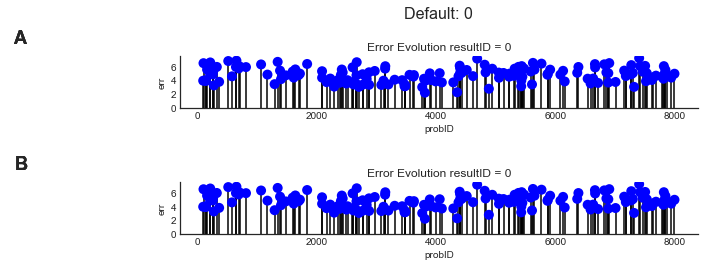
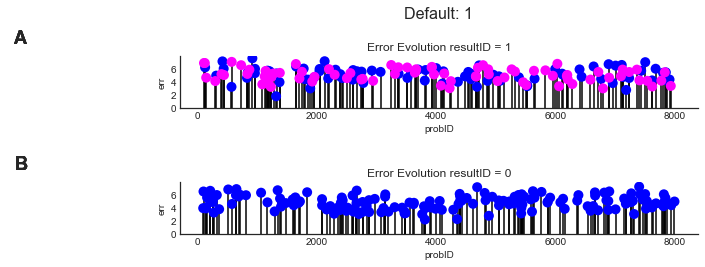
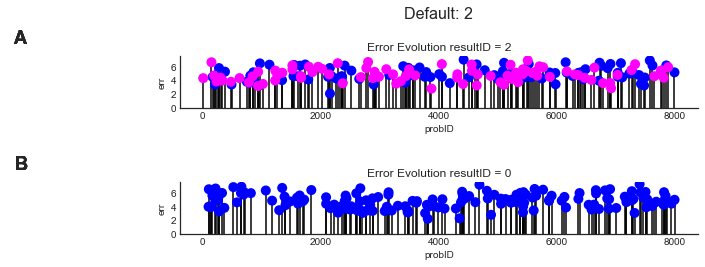
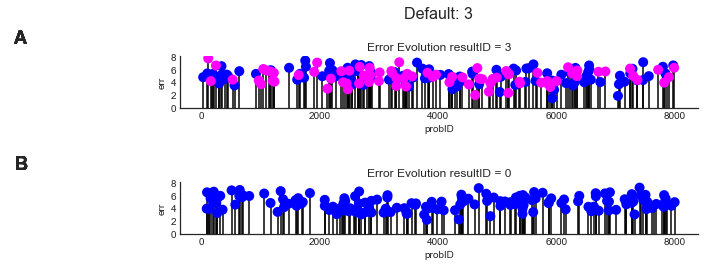
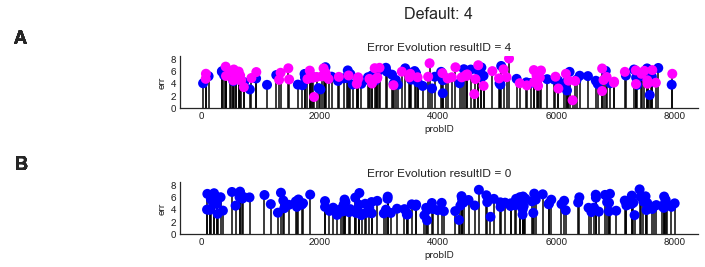
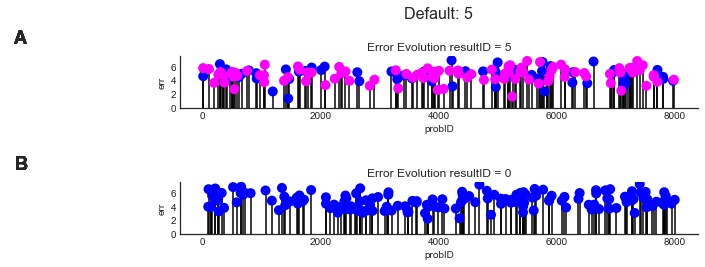
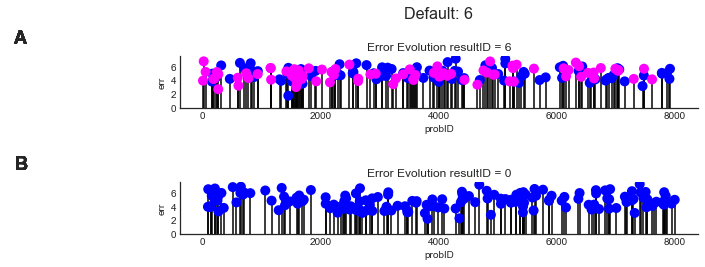
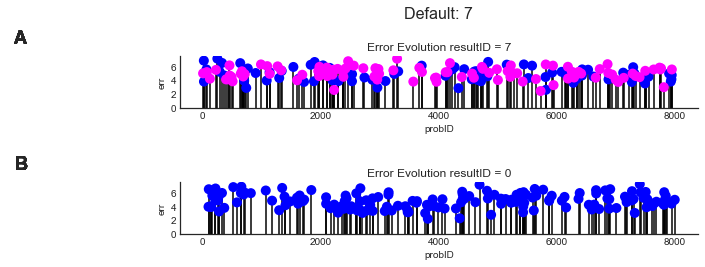
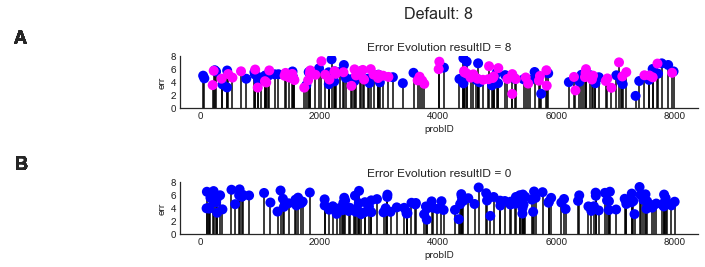
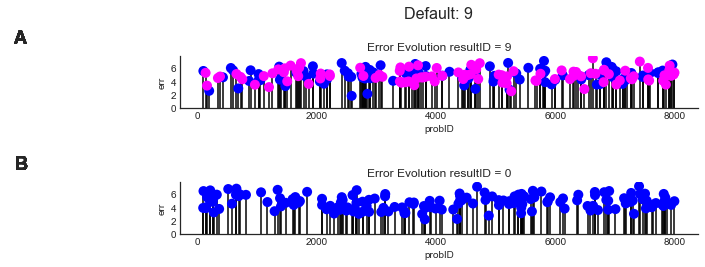
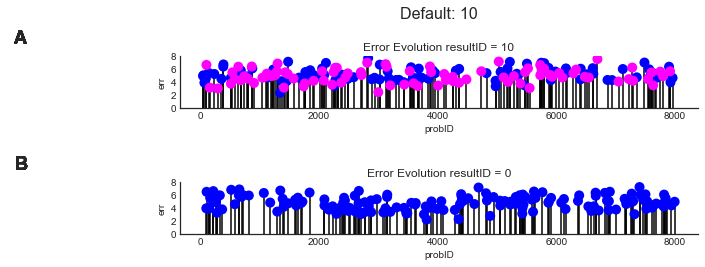
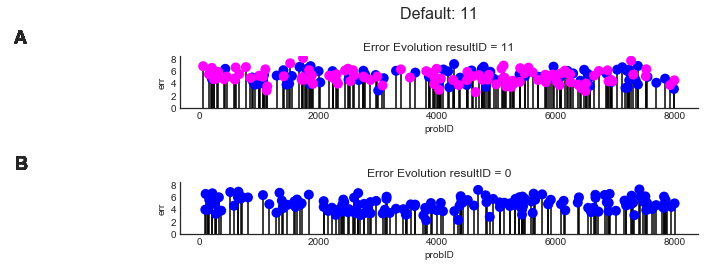
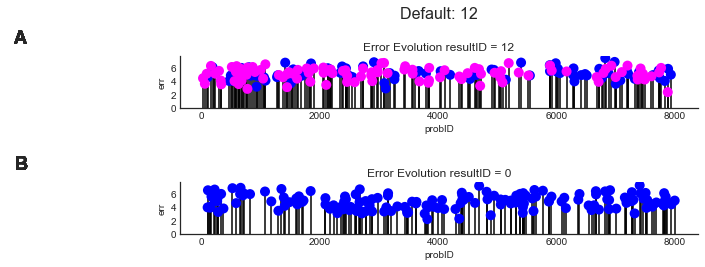
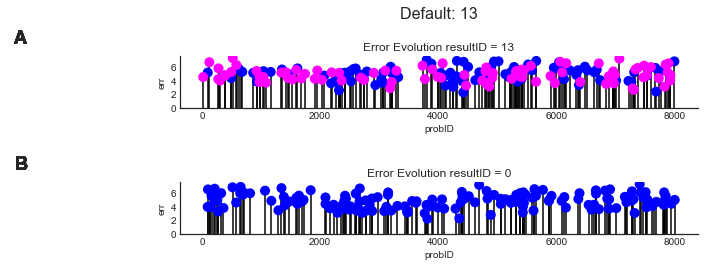
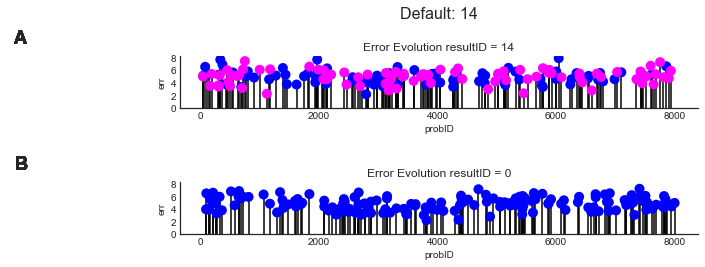
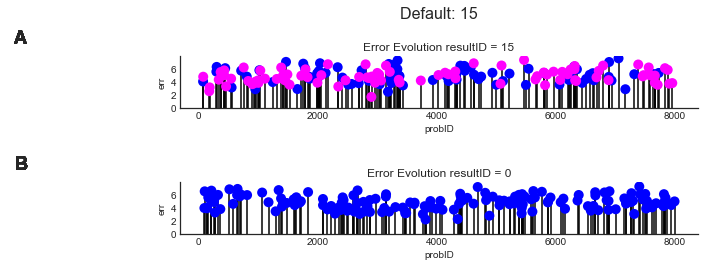
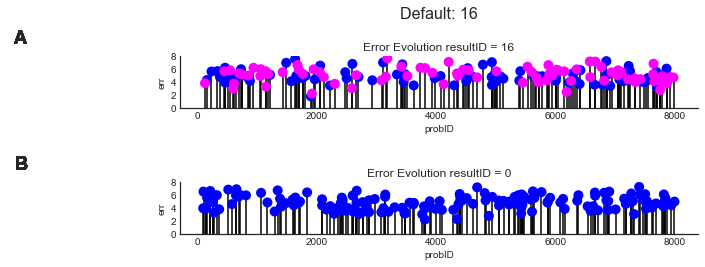
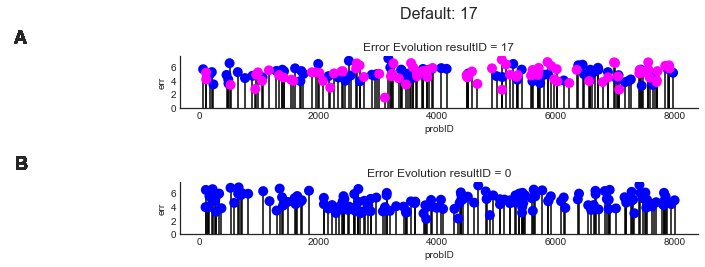
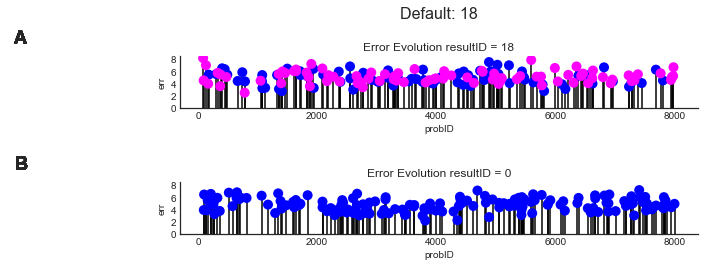
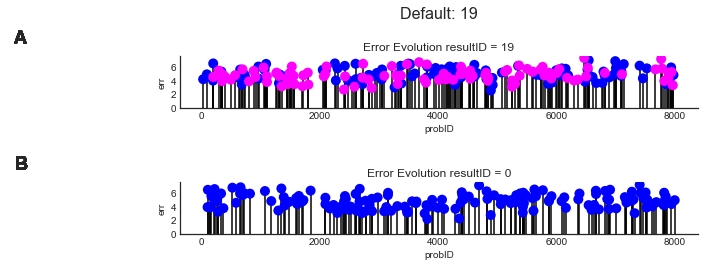
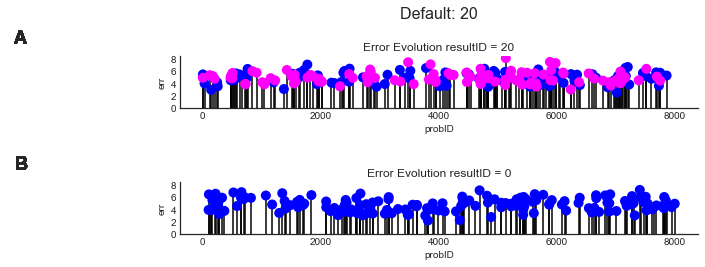
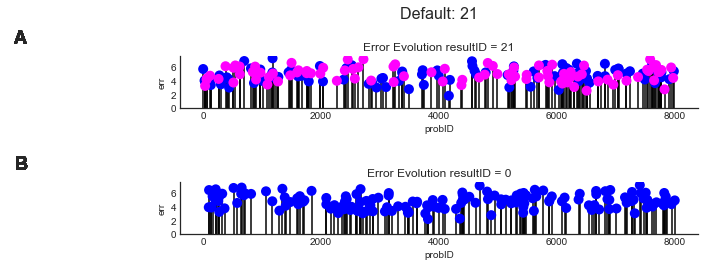
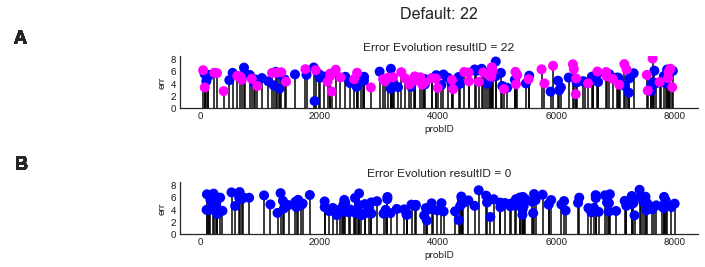
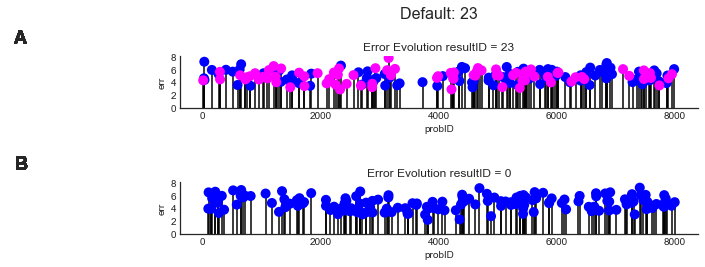
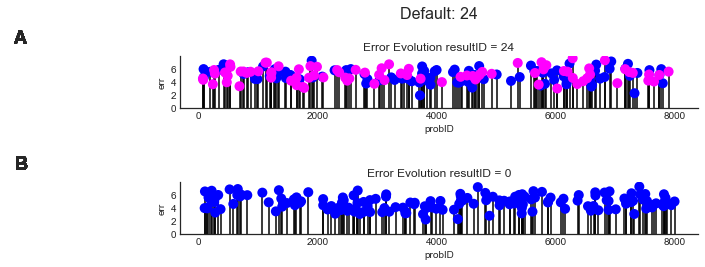
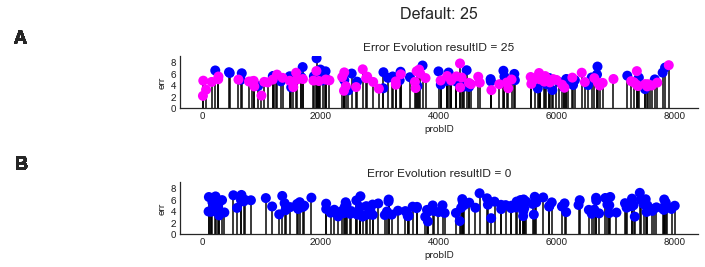
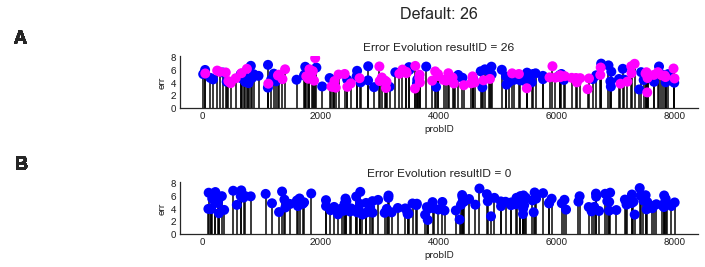
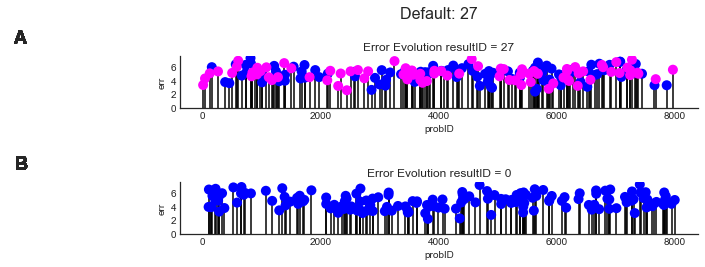
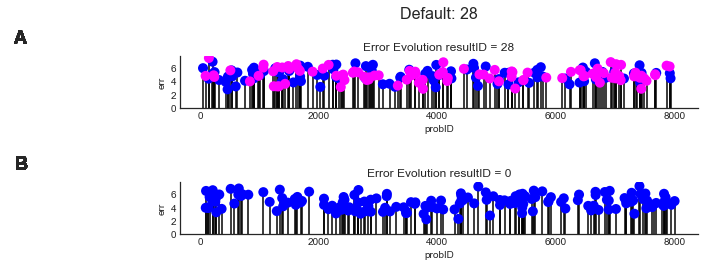
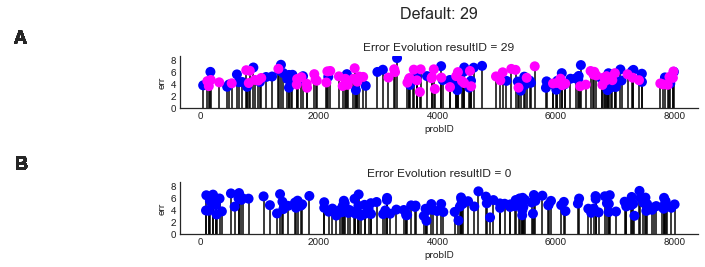
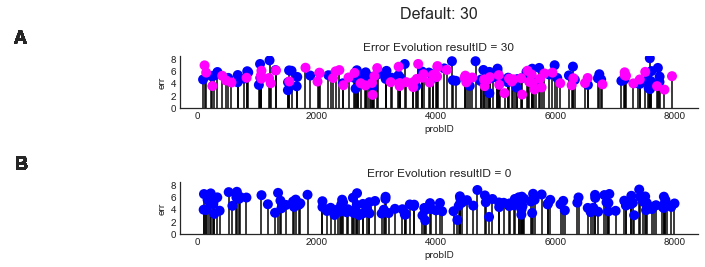
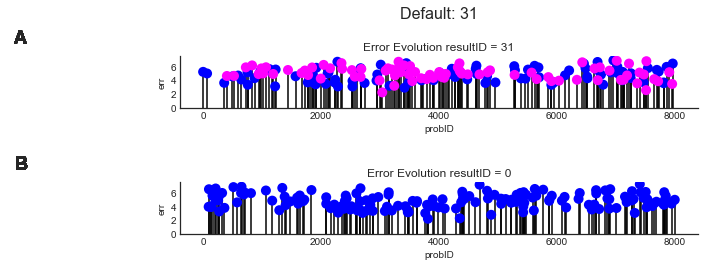
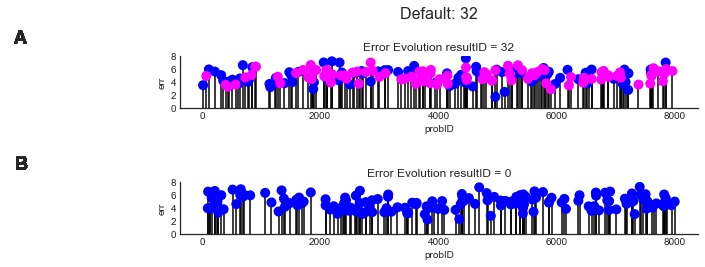
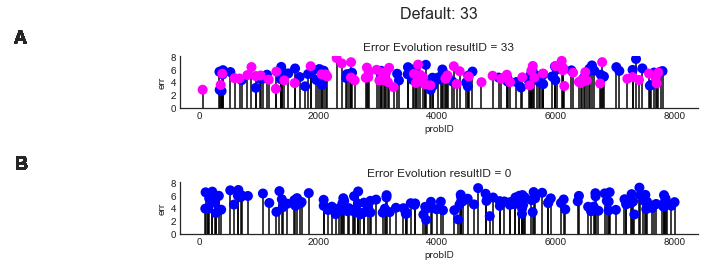
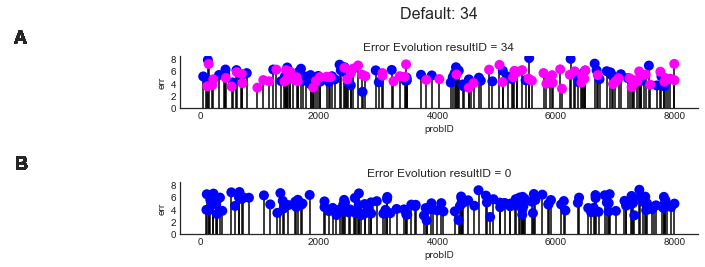
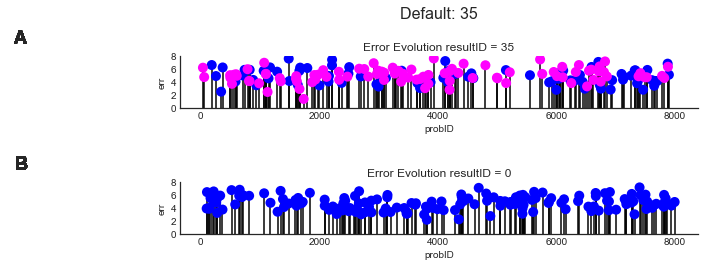
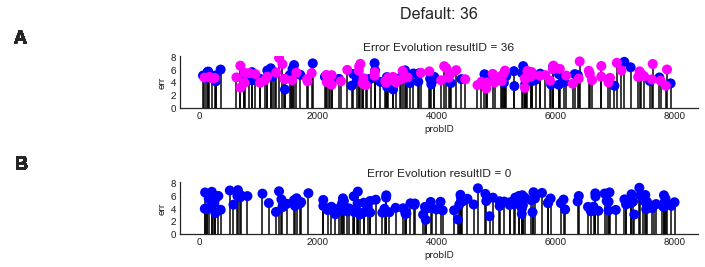
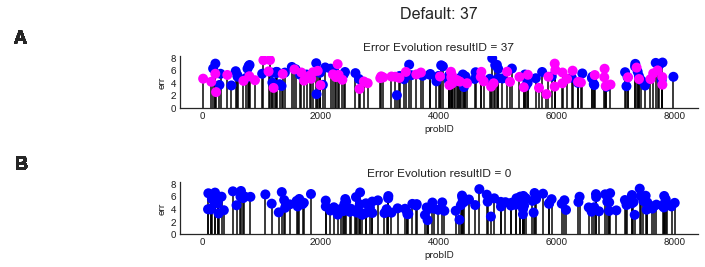
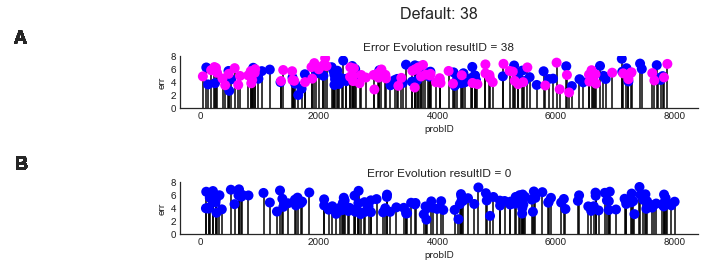
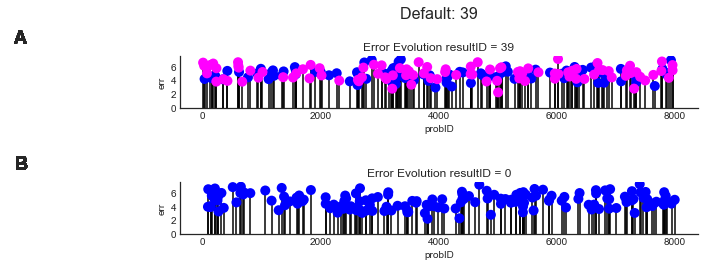
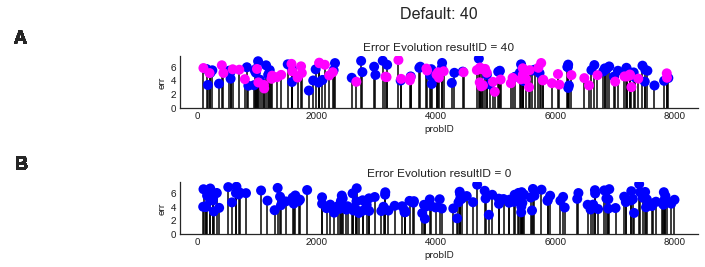
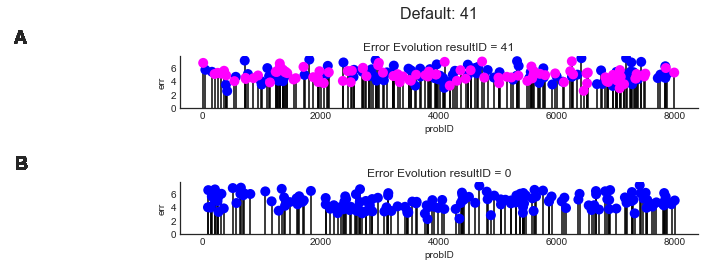
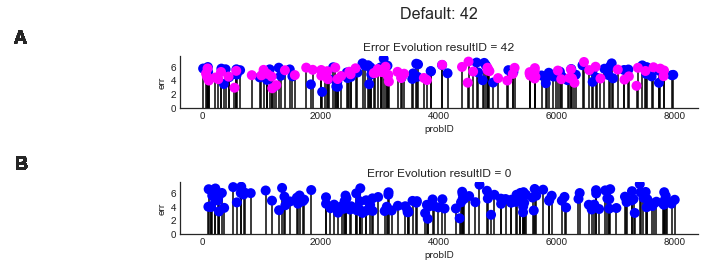
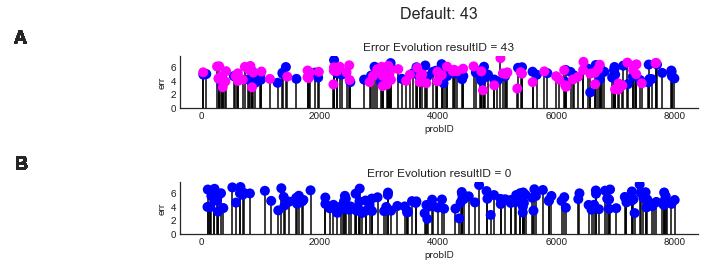

In [3]:
%%output backend='matplotlib'  size=200
%%opts Spikes Scatter {+framewise}

dd_plots = error_evolution_plots(ddf,N,'matplotlib')
(hv.HoloMap(dd_plots)+dd_plots[0]).cols(1)

In [4]:
%%output backend='bokeh'  size=150
%%opts Scatter Spikes {+framewise}
%%opts Scatter [tools=['hover']]
%%opts Overlay [height=200]

dd_plots = error_evolution_plots(ddf,N,'bokeh')
hmap=(hv.HoloMap(dd_plots)+dd_plots[0]).cols(1)
hmap

set bokeh


:Layout
   .HoloMap.Error_Evolution_resultID_equals_0 :HoloMap   [Default]
      :Overlay
         .Spikes.I :Spikes   [probID]   (err)
         .Accept.I :Scatter   [probID]   (err)
         .Reject.I :Scatter   [probID]   (err)
   .Overlay.Error_Evolution_resultID_equals_0 :Overlay
      .Spikes.I  :Spikes   [probID]   (err)
      .Accept.I  :Scatter   [probID]   (err)
      .Scatter.I :Scatter   [probID]   (err)

# Render to SVG

In [5]:
%%output backend='matplotlib'  size=200
dd_plots = error_evolution_plots(ddf,N,'matplotlib')

fig_srcs_svg={}
renderer = hv.Store.renderers['matplotlib'].instance(fig='svg', holomap='gif')
for i in dd_plots.keys():
    fig_src = 'geo_%d'%i
    renderer.save(dd_plots[i],'/tmp/'+fig_src)
    fig_srcs_svg[i] = fig_src+'.svg'

set matplotlib


## Generate a makefile for a document including all the svg files

### Handcoded Version

In [ ]:
def gen_makefile(svg_srcs = fig_srcs_svg ):
    mk_header='''
MAIN := DOC

LATEXMK := latexmk

'''
    mk_footer = '''

FIGS_PGF = $(addprefix /tmp/,$(patsubst %.svg,FIG%.pdf,$(FIG_SRCS_SVG)))

$(MAIN).pdf: $(FIGS_PGF) $(MAIN).tex; $(LATEXMK) --pdf $(MAIN).tex

/tmp/FIG%.pdf: /tmp/%.svg; inkscape -D -z --file=$< --export-pdf=$@ --export-latex

    '''
    l_svg_srcs = [svg_srcs[i] for i in svg_srcs.keys() ]
    with open('/tmp/Makefile','w') as out:
        out.write(mk_header)
        out.write('FIG_SRCS_SVG =\\\n')
        out.write(" \\\n".join(l_svg_srcs))
        out.write("\n\n")
        out.write( mk_footer )

def gen_doc(svg_srcs = fig_srcs_svg ):
    doc_header=\
r'''\documentclass{article}
\usepackage{graphics}
\usepackage{color}
\usepackage[dvipsnames]{xcolor}
\usepackage{svg}
\usepackage[margin=10pt, font=small,labelfont=bf,format=default,indention=.5cm]{caption}
\usepackage{relsize}
\usepackage{fancyvrb}

\usepackage{verbatim}
\usepackage[pdftex,
            final=true,
            hyperfigures=true,
            bookmarks=true,
            bookmarksnumbered=true,
            bookmarksopen=false,
            pdftoolbar=true,
            colorlinks=true,
            urlcolor=webblue,
            linkcolor=webblue
            ]{hyperref}
\hypersetup{
pdfauthor = {},
pdftitle = {Experimental Results Summary},
pdfsubject = {},
pdfkeywords = {},
pdfcreator = {LaTeX with hyperref package},
pdfproducer = {pdflatex}
}
% ---------------------------------------------------------------------------------------------------
\title{Summary}
\author{ea42gh}
%\makeindex

\begin{document}
\maketitle
'''
    doc_summary =\
r'''
\section*{Summary}
\section*{Error Evolution for each problemID}
'''
    doc_figure =\
r'''
\subsection*{Problem ID %d}
\begin{figure}[h]
    \centering
    \def\svgwidth{\columnwidth}
    \input{%s}
\end{figure}
\newpage
'''
    doc_footer =\
r'''
\end{document}
'''
    with open('/tmp/DOC.tex', 'w') as out:
        out.write( doc_header )
        for i in svg_srcs.keys():
            out.write( doc_figure %(i, "FIG"+svg_srcs[i].replace('.svg','.pdf_tex') ) )
        out.write( doc_footer )

gen_makefile()
gen_doc()
!cd /tmp; make

### Jinja2 Template Version
See http://jinja.pocoo.org/docs/2.9/templates/#list-of-control-structures

In [46]:
t_makefile = Template(\
'''MAIN := {{doc_name}}

LATEXMK := latexmk

FIG_SRCS_SVG = \\
{% for _,value in svg_figs.items()%}   {{ value|e }} \\
{% endfor %}   $(eof)

FIGS_PGF = $(addprefix {{fig_in_dir}}/,$(patsubst %.svg,FIG_%.pdf,$(addprefix {{fig_out_dir}}/,$(FIG_SRCS_SVG))))

$(MAIN).pdf: $(FIGS_PGF) $(MAIN).tex; $(LATEXMK) --pdf $(MAIN).tex

{{fig_out_dir}}/FIG_%.pdf: {{FIG_IN_DIR}}/%.svg; inkscape -D -z --file=$< --export-pdf=$@ --export-latex
'''                    
)
print(t_makefile.render(doc_name='Doc',fig_in_dir='/tmp',fig_out_dir='/tmp',svg_figs=fig_srcs_svg) )

MAIN := Doc

LATEXMK := latexmk

FIG_SRCS_SVG = \
   geo_0.svg \
   geo_1.svg \
   geo_2.svg \
   geo_3.svg \
   geo_4.svg \
   geo_5.svg \
   geo_6.svg \
   geo_7.svg \
   geo_8.svg \
   geo_9.svg \
   geo_10.svg \
   geo_11.svg \
   geo_12.svg \
   geo_13.svg \
   geo_14.svg \
   geo_15.svg \
   geo_16.svg \
   geo_17.svg \
   geo_18.svg \
   geo_19.svg \
   geo_20.svg \
   geo_21.svg \
   geo_22.svg \
   geo_23.svg \
   geo_24.svg \
   geo_25.svg \
   geo_26.svg \
   geo_27.svg \
   geo_28.svg \
   geo_29.svg \
   geo_30.svg \
   geo_31.svg \
   geo_32.svg \
   geo_33.svg \
   geo_34.svg \
   geo_35.svg \
   geo_36.svg \
   geo_37.svg \
   geo_38.svg \
   geo_39.svg \
   geo_40.svg \
   geo_41.svg \
   geo_42.svg \
   geo_43.svg \
   $(eof)

FIGS_PGF = $(addprefix /tmp/,$(patsubst %.svg,FIG_%.pdf,$(addprefix /tmp/,$(FIG_SRCS_SVG))))

$(MAIN).pdf: $(FIGS_PGF) $(MAIN).tex; $(LATEXMK) --pdf $(MAIN).tex

/tmp/FIG_%.pdf: /%.svg; inkscape -D -z --file=$< --export-pdf=$@ --export-latex


In [51]:
t_doc = Template(\
r'''\documentclass{article}
\usepackage{graphics}
\usepackage{color}
\usepackage[dvipsnames]{xcolor}
\usepackage{svg}
\usepackage[margin=10pt, font=small,labelfont=bf,format=default,indention=.5cm]{caption}
\usepackage{relsize}
\usepackage{fancyvrb}

\usepackage{verbatim}
\usepackage[pdftex,
            final=true,
            hyperfigures=true,
            bookmarks=true,
            bookmarksnumbered=true,
            bookmarksopen=false,
            pdftoolbar=true,
            colorlinks=true,
            urlcolor=webblue,
            linkcolor=webblue
            ]{hyperref}
\hypersetup{
pdfauthor = {},
pdftitle = {Experimental Results Summary},
pdfsubject = {},
pdfkeywords = {},
pdfcreator = {LaTeX with hyperref package},
pdfproducer = {pdflatex}
}
% ---------------------------------------------------------------------------------------------------
\title{Summary}
\author{ea42gh}
%\makeindex

\begin{document}
\maketitle
{% for key, value in svg_figs.items() %}
\section*{Problem ID {{key}}}
\begin{figure}[h]
    \centering
    \def\svgwidth{\columnwidth}
    \input{ {{value}} }
\end{figure}
{% endfor %}
\end{document}
'''
)
print(t_doc.render(doc_name='Doc',fig_out_dir='/tmp',svg_figs=fig_srcs_svg) )

\documentclass{article}
\usepackage{graphics}
\usepackage{color}
\usepackage[dvipsnames]{xcolor}
\usepackage{svg}
\usepackage[margin=10pt, font=small,labelfont=bf,format=default,indention=.5cm]{caption}
\usepackage{relsize}
\usepackage{fancyvrb}

\usepackage{verbatim}
\usepackage[pdftex,
            final=true,
            hyperfigures=true,
            bookmarks=true,
            bookmarksnumbered=true,
            bookmarksopen=false,
            pdftoolbar=true,
            colorlinks=true,
            urlcolor=webblue,
            linkcolor=webblue
            ]{hyperref}
\hypersetup{
pdfauthor = {},
pdftitle = {Experimental Results Summary},
pdfsubject = {},
pdfkeywords = {},
pdfcreator = {LaTeX with hyperref package},
pdfproducer = {pdflatex}
}
% ---------------------------------------------------------------------------------------------------
\title{Summary}
\author{ea42gh}
%\makeindex

\begin{document}
\maketitle

\section*{Problem ID 0}
\begin{figure}[h]
    \centering
    \d

# Stuff to be looked at later...

obj.map(pad_points, hv.Scatter)

specs basically allows one of the following:
*   A HoloViews type to match, e.g. hv.Scatter
*   A type{[.group].label] string, e.g. 'Scatter.Scatter.I'
*   A function
*   Or a list of any combination of the above, where a match in any of the conditions means a match.

:Overlay
   .Spikes.I   :Spikes   [probID]   (err)
   .Scatter.I  :Scatter   [probID]   (err)
   .Scatter.II :Scatter   [probID]   (err)
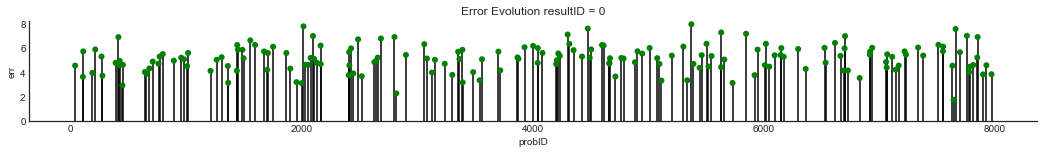

In [68]:
%%output backend='matplotlib'
dd_plots[0].map( lambda x: x.opts(style=dict(color='green'),plot=dict(aspect=5, figsize=500)), hv.Scatter)

:Layout
   .Overlay.Error_Evolution_resultID_equals_0 :Overlay
      .Spikes.I  :Spikes   [probID]   (err)
      .Accept.I  :Scatter   [probID]   (err)
      .Scatter.I :Scatter   [probID]   (err)
   .Overlay.Error_Evolution_resultID_equals_1 :Overlay
      .Spikes.I :Spikes   [probID]   (err)
      .Accept.I :Scatter   [probID]   (err)
      .Reject.I :Scatter   [probID]   (err)
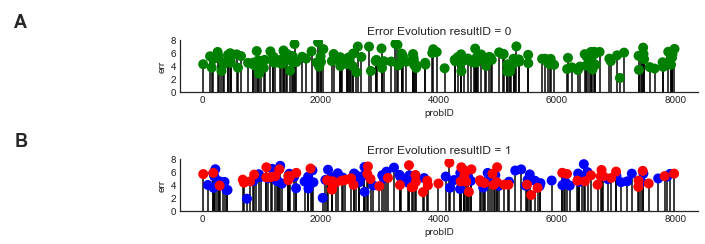

In [104]:
%%output backend='matplotlib' size=200
(dd_plots[0].map( lambda x: x.opts(style=dict(color='green'),plot=dict(aspect=5, figsize=500)), hv.Scatter)+\
 dd_plots[1].map( lambda x: x.opts(style=dict(color='red'),  plot=dict(aspect=5, figsize=500)), 'Scatter.Reject')).cols(1)

In [96]:
print(dd_plots[1])

:Overlay
   .Spikes.I :Spikes   [probID]   (err)
   .Accept.I :Scatter   [probID]   (err)
   .Reject.I :Scatter   [probID]   (err)


to affect the second plot above, the element in question needs to have a group label